In [1]:
dataset = "P-SET"
llm_type = "llama3.1:70b"
prompt_version=4
suffix = f"v{prompt_version}"


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

def plot_confusion_matrices_for_column_pairs(df, gt_col,vis_columns):

    n_pairs = len(vis_columns)

    # Determine layout: square-ish grid
    n_cols = int(np.ceil(np.sqrt(n_pairs)))
    n_rows = int(np.ceil(n_pairs / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
    axes = axes.flatten()
    col1 = gt_col
    for idx, col2 in enumerate(vis_columns):
        ax = axes[idx]
        
        # Drop rows with missing values in either column
        sub_df = df[[col1, col2]].dropna().copy()
        start_length = len(sub_df)
        # sub_df = sub_df[sub_df.apply(lambda x: True if ("_" not in x[col1] and '_' not in x[col2]) else False, axis=1)]
        filter_length = len(sub_df)
        # Get confusion matrix
        labels = sorted(set(sub_df[col1]) | set(sub_df[col2]))
        cm = confusion_matrix(sub_df[col1], sub_df[col2], labels=labels)

        # Plot heatmap
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
        ax.set_title(f"{col1} vs \n{col2}\n strt: {start_length}\nelim.:{filter_length-start_length}", fontsize=10)
        ax.set_xlabel(col2)
        ax.set_ylabel(col1)

    # Hide any extra axes
    for j in range(len(vis_columns), len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    return fig


In [3]:
from collections import Counter
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
import string
nltk.download('punkt_tab')

# Download tokenizer models if not already available
nltk.download('punkt')


def flatten_list_of_lists(nested_list):
    return [item for sublist in nested_list for item in sublist]


# Ensure required resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

def most_frequent_ngrams(sentences, N=5):
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)

    all_unigrams = []
    all_bigrams = []
    all_trigrams = []

    for sentence in sentences:
        tokens = word_tokenize(sentence.lower())
        # Remove stopwords and punctuation
        filtered_tokens = [t for t in tokens if t not in stop_words and t not in punctuation]

        all_unigrams.extend(filtered_tokens)
        all_bigrams.extend(ngrams(filtered_tokens, 2))
        all_trigrams.extend(ngrams(filtered_tokens, 3))

    # Count frequencies
    unigram_counts = Counter(all_unigrams)
    bigram_counts = Counter(all_bigrams)
    trigram_counts = Counter(all_trigrams)

    # Get top N most common
    most_common_unigram = unigram_counts.most_common(N)
    most_common_bigram = bigram_counts.most_common(N)
    most_common_trigram = trigram_counts.most_common(N)

    return {
        'most_common_unigram': most_common_unigram,
        'most_common_bigram': most_common_bigram,
        'most_common_trigram': most_common_trigram
    }


most_frequent_ngrams(["apple ate orange", "orange at babana", "apple ate", "orange at babana to"])

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/asusaiyah/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/asusaiyah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to /home/asusaiyah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/asusaiyah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'most_common_unigram': [('orange', 3),
  ('apple', 2),
  ('ate', 2),
  ('babana', 2)],
 'most_common_bigram': [(('apple', 'ate'), 2),
  (('orange', 'babana'), 2),
  (('ate', 'orange'), 1)],
 'most_common_trigram': [(('apple', 'ate', 'orange'), 1)]}

********************Sleep************************
['../exports/05b_llm_llama3.1:70b_P-SET_v4/Sleep/Sleep_Sentences_att_True.pkl']
Sleep_Sentences_att_True
Ao True Sleep_Sentences_att_True
****************Sentence**************


is_keyword_present
1.0    297
0.0    294
Name: count, dtype: int64

Sent_gt_Sleep  is_keyword_present
False          0.0                   294
True           1.0                   251
False          1.0                    46
Name: count, dtype: int64
Event_Name_Sleep
Event_Name_LLM_Events_example_evidence_Sent_Sleep
false_positive_keywords: {'most_common_unigram': [('sleep', 13), ('patient', 8), ('sleeping', 6), ('stated', 3), ('monitor', 2), ('apnea', 2), ('bedside', 2), ('ordered', 2), ('pill', 2), ('ativan', 2), ('anesthesia', 2), ('wanted', 2), ('asleep', 2), ('bipap', 2), ('would', 2)], 'most_common_bigram': [(('wanted', 'sleep'), 2), (('patient', 'stated'), 2), (('monitor', 'resp'), 1), (('resp', 'sts/sleep'), 1), (('sts/sleep', 'apnea'), 1), (('oral', 'airway'), 1), (('airway', 'piece'), 1), (('piece', 'bedside'), 1), (('bedside', 'sleep'), 1), (('sleep', 'apnea'), 1), (('sedation/sleep', 'meds'), 1), (('robitussin', 'codiene'), 1), (('codiene', 'ordered'), 1), (('ordered', 'hs'), 1), (('hs', 'aide'), 1)], 'most_common_trigram': [(('monitor', 'r

/scratch-local/74866/ipykernel_3693158/1404767904.py:244: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(clean_illegal_chars)


file written to ../exports/06b_analysis/llama3.1:70b_V4/Sleep/all_correct_Sleep_Sentences_att_True.xlsx


,col_name,technique,pos_sup,neg_sup,accuracy,accuracy-CI,f1_score,precision,precision-CI,recall,recall-CI,TP,TN,FP,FN,time
0,Event_Name_Sleep,Sleep_Ao,251,340,0.922,"[0.901,0.944]",0.916,0.845,"[0.804,0.886]",1.000,"[1.000,1.000]",251,294,46,0,0.003
1,Event_Name_LLM_Events_example_evidence_Sent_Sleep,LLM__Ei_Sent_Ao,251,340,0.934,"[0.914,0.954]",0.925,0.898,"[0.862,0.935]",0.952,"[0.926,0.979]",239,313,27,12,4.549


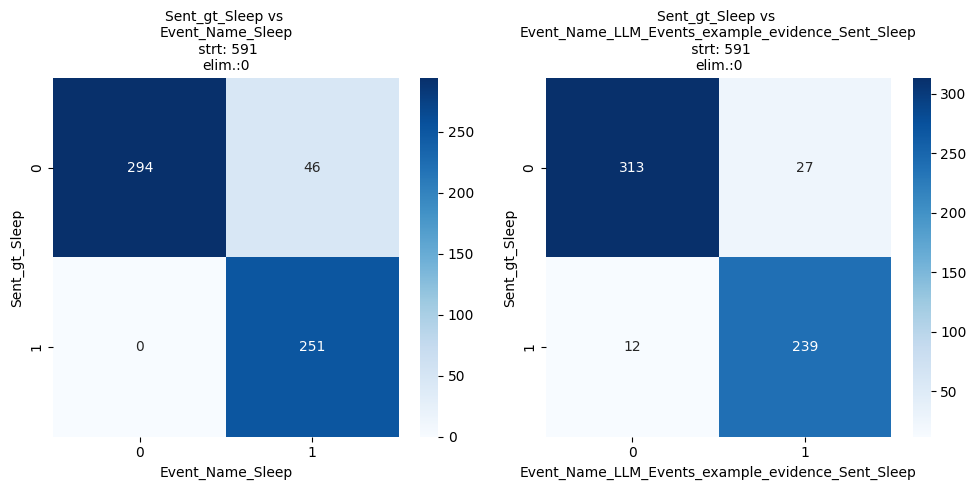

In [ ]:
from glob import glob
import os
import pandas as pd
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from itertools import product
from statsmodels.stats.proportion import proportion_confint

pd.set_option("display.precision", 3)


disagreement_type = "correct"
from tqdm import tqdm
import re
from openpyxl.cell.cell import ILLEGAL_CHARACTERS_RE
def clean_illegal_chars(val):
    if isinstance(val, str):
        return ILLEGAL_CHARACTERS_RE.sub("", val)
    return val

def get_time(x):
    x = np.array(x)
    # Remove NaNs
    x = x[~np.isnan(x)]
    # If less than 3 values, just return mean
    if len(x) < 3:
        return np.mean(x)
    # Remove outliers using IQR
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    mask = (x >= q1 - 1.5 * iqr) & (x <= q3 + 1.5 * iqr)
    return np.mean(x[mask])

def fixnames(ls,suffix,remove):
    LS=[]
    for s in ls:
        s = s.replace("_keyword_evidence","_Ki").replace("_example_evidence","_Ei").replace("_no_evidence","").replace("_all_evidence","KiEi").replace("Event_Name_",'').replace("_Events",'_').replace('_'+remove,"")
        s = s + "_" + suffix
        if "sentence" in s:
            s = s.replace("sentence","")
            s = s + "_Sent-SET"
        elif "document" in s:
            s = s.replace("document","")
            s = s + "_Doc-SET"
        LS.append(s)
    return LS

def get_col_suffix(keyword_input, example_input):
    col_suffix = "no"
    if keyword_input and example_input:
        col_suffix = "all"
    elif keyword_input and not example_input:
        col_suffix = "keyword"
    elif not keyword_input and example_input:
        col_suffix = "example"
    return col_suffix

LLM_dict = {}
llm_models_all = []
for keyword_input, example_input in [i for i in product([True,False],[True,False])]: 
    for input_type in ["Sent", "Doc"]:
        col_suffix = get_col_suffix(keyword_input, example_input)
        llm_models_all.append(f"LLM_Events_{col_suffix}_evidence_{input_type}")
df_both = pd.read_pickle("../exports/04b_dictionary_features.pkl")


def infer_gt(row, col, ET):
    # return 1 if ET in row[col] else 0
    if col.replace('Event_Name','Actor') in row:
        res = any([1 if ((e==ET and a=='patient') or (e==ET and ET=='Family')) else 0 for e,a in zip(row[col], row[col.replace('Event_Name','Actor')])])
    else:
        res = 1 if ET in row[col] else 0
    return res

def ispresent(a,b):
    res = []
    for i in a:
        presence = False
        for j in b:
            if (i in j) or (j in i):
                presence = True
                break
        res.append(presence)
    return res

dataset = "P-SET"
for analysis_type in ["all"]: #(M-SET, A-SET, D-SET, F-SET)
    for ET in ["Sleep"]:
        print(f"********************{ET}************************")
        llm_files = glob(f"../exports/05b_llm_{llm_type}_{dataset}_{suffix}/{ET}/*.pkl")
        print(llm_files)
        try:
            gt_file_sent = glob(f"../exports/04c_groundtruth/{dataset}/Annotated/{ET}_Sentences.pkl")[0]
            gt_file_doc = glob(f"../exports/04c_groundtruth/{dataset}/Annotated/{ET}_Documents.pkl")[0]
        except IndexError:
            print(f"No ground truth file found for {ET} in ../exports/04c_groundtruth/{dataset}/Annotated/")
            continue    
        
        llm_files = [i for i in llm_files if "True" in i]
        llm_files = [i for i in llm_files if "Sent" in i]
        for file in llm_files:
            filename = os.path.basename(file).rstrip('.pkl')
            print(filename)
            text_type = "Document" if "Document" in filename else "Sentence"
            _,attribute_requested = filename.split("_")[-2:]
            attribute_requested = eval(attribute_requested)
            suffix = "Ao" if attribute_requested else ""           
            print(suffix,attribute_requested,filename)
            
            if text_type == "Sentence":
                gt_file = gt_file_sent
                id_type = "UID"
                focus = "Sent"
                gt_column = f"Sent_gt_{ET}"
            elif text_type == "Document":
                gt_file = gt_file_doc
                id_type = "ROW_ID"
                focus = "Doc"
                gt_column = f"Doc_gt_{ET}"
            print(f"****************{text_type}**************")
            gt_df = pd.read_pickle(gt_file)
            gt_df[id_type] = gt_df[id_type].astype(str)
            df_both[id_type] = df_both[id_type].astype(str)
            gt_df = gt_df.dropna(subset=gt_column)
            if not attribute_requested:
                gt_df[gt_column] = gt_df.apply(lambda x: x[gt_column] if x['negation']==False else False,axis=1)
            
            gt_df['Lemma'] = gt_df['Lemma'].apply(lambda x: tuple(x))
            gt_df["is_keyword_present"] = gt_df["Event_Name"].apply(lambda x: 1 if ET in x else 0)
            
            id_to_gt = {row[id_type]:row[gt_column] for _,row in gt_df.iterrows()}
            id_to_negation = {row[id_type]:row['negation'] for _,row in gt_df.iterrows()}
            id_to_key_present = {row[id_type]:row[f"is_keyword_present"] for _,row in gt_df.iterrows()}
            id_to_lemma = {row[id_type]:row[f"Lemma"] for _,row in gt_df.iterrows()}
            id_to_comment = {row[id_type]:row[f"comment"] for _,row in gt_df.iterrows()}
            id_to_dict_time = {row[id_type]:row[f"Time"] for _,row in df_both.iterrows()}
            
            output_folder = f"../exports/06b_analysis/{llm_type}_V{prompt_version}/{ET}"
            os.makedirs(output_folder,exist_ok=True)
       
            
            
            df = pd.read_pickle(file)
            df["num_events_keyword"] = df["Event_Name"].apply(lambda x: len(x))
            df[f"num_{ET}_keyword"] = df["Event_Name"].apply(lambda x: len([i for i in x if i == ET]))
            df[id_type] = df[id_type].astype(str)
            llm_models = [i for i in llm_models_all if i in df]
            df[f'{ET}_time'] = df[id_type].apply(lambda x:id_to_dict_time.get(x))
            df["focus_event"] = ET
            df['negation'] = df[id_type].apply(lambda x:id_to_negation.get(x))
            df['comment'] = df[id_type].apply(lambda x:id_to_comment.get(x))
            
            
            df[gt_column] = df[id_type].apply(lambda x:id_to_gt.get(x,None))
            df[f"is_keyword_present"] = df[id_type].apply(lambda x:id_to_key_present.get(x))
            display(df.is_keyword_present.value_counts())
            print(df[[gt_column,"is_keyword_present"]].value_counts())
                        
            df[f"dict_Lemma"] = df[id_type].apply(lambda x:id_to_lemma.get(x))
            df.dropna(subset=gt_column,inplace=True)
            df[gt_column] = df[gt_column].astype(int)
            
            

            for col in llm_models:
                df[f"{col}_{ET}_time"] = df[col].apply(lambda x:x['event_detection_time'])
                
            if len(df) > 1:
                first_row = df.iloc[0]
                splittable_columns = ["Event_Name"]+[f"Event_Name_{model}" for model in llm_models]
                disagreement_dfs = []
                generated_columns = []

                for col in splittable_columns:
                    generated_column = f"{col}_{ET}"
                    df[generated_column] = df.apply(lambda x: infer_gt(x,col,ET), axis=1)
                    
                    generated_columns.append(generated_column)
                
                f1s, accs, precs, recs, psup, nsup, times, tp, tn, fp, fn, cia, cif, cip, cir = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
                
                
                for col in generated_columns:
                    print(col)
                    df_temp = df.copy()
                    y_gt = df_temp[gt_column]
                    LLM_dict[(attribute_requested,gt_column)] = y_gt
                    preds = df_temp[col]
                    LLM_dict[(attribute_requested,col)] = preds
                    f1s.append(f1_score(y_gt, preds))
                    accs.append(accuracy_score(y_gt, preds))
                    precs.append(precision_score(y_gt, preds, zero_division=0))
                    recs.append(recall_score(y_gt, preds))   
                    psup.append(sum(y_gt))
                    nsup.append(sum(y_gt==0))
                    times.append(get_time(df_temp[f"{col.lstrip('Event_Name_')}_time"]))
                    tn_i, fp_i, fn_i, tp_i = confusion_matrix(y_gt, preds).ravel()
                    prec_ci_low, prec_ci_high = proportion_confint(tp_i, tp_i + fp_i, alpha=0.05, method='normal')
                    recall_ci_low, recall_ci_high = proportion_confint(tp_i, tp_i + fn_i, alpha=0.05, method='normal')
                    acc_ci_low, acc_ci_high = proportion_confint(tp_i + tn_i, tp_i + fn_i + fp_i + tn_i, alpha=0.05, method='normal')

                    tp.append(tp_i)
                    tn.append(tn_i)
                    fp.append(fp_i)
                    fn.append(fn_i)
                    cip.append(f"[{prec_ci_low:0.3f},{prec_ci_high:0.3f}]")
                    cir.append(f"[{recall_ci_low:0.3f},{recall_ci_high:0.3f}]")
                    cia.append(f"[{acc_ci_low:0.3f},{acc_ci_high:0.3f}]")
                    
                    
                    if "example_evidence" in col:
                        col_base = col.lstrip("Event_Name_").rstrip(f"_{ET}")
                        df[f"Text_Quote_{col_base}_{ET}"] = df.apply(lambda x:[t for t,e in zip(x[f"Text_Quote_{col_base}"],x[f"Event_Name_{col_base}"]) if e==ET],axis=1)
                        df[f"Attribute_{col_base}_{ET}"] = df.apply(lambda x:[a for a in (x[f"Attribute_{col_base}"]) if list(a.keys())[0]==ET],axis=1)
                        df[f"Event_Id_{col_base}"] = df[col_base].apply(lambda x:[ f"{eid}={en}|{1 if tq in x['text'] else 0}:{tq}" for (eid,en,tq) in zip(x['event_id'],x['event'],x['text_quotes'])])
                        df[f"Text_Quote_in_gt"] = df.apply(lambda x:ispresent(x[f"Text_Quote_{col_base}_{ET}"], x['comment'].split('|')), axis=1)

                        interesting_columns = [id_type, text_type, gt_column, 
                                               "is_keyword_present",
                                               f"Event_Name_{ET}", "comment", "negation", 
                                               col, "Text_Quote_in_gt",
                                               f"Text_Quote_{col_base}_{ET}",
                                               f"Attribute_{col_base}_{ET}"]+[i+col_base for i in ["Event_Name_","Attribute_","Text_Quote_", "Event_Id_","Order_"]] 
                        
                        
                        false_positive_samples = df[(df[col]!=df[gt_column])&(df[col]==1)]
                        false_positive_samples[interesting_columns].to_excel(f"{output_folder}/FP_{col}.xlsx")
                        print("false_positive_keywords:",most_frequent_ngrams(flatten_list_of_lists(false_positive_samples[f"Text_Quote_{col_base}_{ET}"].to_list()),15))
                        false_negative_samples = df[(df[col]!=df[gt_column])&(df[col]==0)]
                        false_negative_samples[interesting_columns].to_excel(f"{output_folder}/FN_{col}.xlsx")
                        # print("false_negative_keywords:",most_frequent_ngrams(flatten_list_of_lists(false_positive_samples[f"comment"].to_list()),10))
                        true_positive_samples = df[(df[col]==df[gt_column])&(df[gt_column]==1)]
                        true_positive_samples[interesting_columns].to_excel(f"{output_folder}/TP_{col}.xlsx")
                        true_negative_samples = df[(df[col]==df[gt_column])&(df[gt_column]==0)]
                        true_negative_samples[interesting_columns].to_excel(f"{output_folder}/TN_{col}.xlsx")
                        print("TP",len(true_positive_samples),"TN",len(true_negative_samples),"FP",len(false_positive_samples),"FN",len(false_negative_samples),"%%%%%%%%%%%%%%%%%%%%%%%")
           
                results_df = {"col_name":generated_columns, "technique":fixnames(generated_columns,suffix,ET), "pos_sup": psup, "neg_sup": nsup, "accuracy":accs,"accuracy-CI":cia,"f1_score":f1s, "precision":precs, "precision-CI":cip,"recall":recs, "recall-CI":cir, "TP":tp, 'TN':tn, 'FP':fp, 'FN':fn, "time":times} 
                results = pd.DataFrame(results_df)   
                plot_confusion_matrices_for_column_pairs(df, gt_column,vis_columns=generated_columns)
                op_path = f"{output_folder}/{analysis_type}_{disagreement_type}_{filename}.xlsx"
                df = df.applymap(clean_illegal_chars)
                df.to_excel(op_path,index=False)
                print(f"file written to {op_path}")
                display(results)
                

In [17]:
proportion_confint(451, 451 + 87, alpha=0.05, method='normal'),proportion_confint(439, 439 + 47, alpha=0.05, method='normal')

((0.8071783464710964, 0.8694015791794611),
 (0.8770152358176666, 0.9295691263222512))

In [16]:
439 +47

486

In [13]:
splittable_columns[1].replace('Event_Name','Actor') in df

True

In [1]:
false_negative_samples[text_type].tolist()

NameError: name 'false_negative_samples' is not defined

In [18]:
df[f"Text_Quote_in_gt"] = df.apply(lambda x:[((i in j) or (j in i)) for (i,j) in product(x[f"Text_Quote_{col_base}_{ET}"], x['comment'])], axis=1)


In [ ]:
true_positive_samples[interesting_columns]

In [59]:
print(df.LLM_Events_example_evidence_Sent.iloc[2]['event_name_prompt'])
print(df.LLM_Events_example_evidence_Sent.iloc[2]['raw_output'])


        **Classification and Attribute Extraction Task** 
            Classify the following sentence into events that took place DURING THE SHIFT in which this note was written, 
            using one or more of the following categories: Eating : The patient takes food into their body by mouth. Identifed Always
Excretion : The patient discharges waste matter from their body. Identifed Always
Family : The patient has a visit, call, or communication with a family member.
Pain : The patient reports or shows signs of pain. Identifed Always
Sleep : The patient sleeps or the sleep’s quality or quantity is described. Identifed Always.
Unknown : choose "Unknown" if none of the other event type are applicable.. 
            If the event talks about a patient's history (before the shift) or future plan of an event (after the shift), DO NOT EXTRACT that event. Consider events ONLY if they relate to the patient (e.g., exclude caregivers' or family members' own experiences of Sleep/Excretion/Pain

In [58]:
ET='Sleep'
y_gt = df.negation
preds=df.apply(lambda x: any([1 if (e==ET and n==True) else 0 for (e,n) in zip(x['Event_Name_LLM_Events_example_evidence_Sent'],x['Negation_LLM_Events_example_evidence_Sent'])]),axis=1)
precision_score(y_gt, preds, zero_division=0),recall_score(y_gt, preds)

(0.5416666666666666, 0.9285714285714286)

In [53]:
df['LLM_Events_example_evidence_Sent'].iloc[0]

{'text': '.sleeping',
 'event': ['Sleep'],
 'event_id': ['e1'],
 'phrase': '',
 'raw_output': '{\n  "case_attributes": [],\n  "events": [\n    {\n      "event_id": "e1",\n      "event_type": "Sleep",\n      "text_quote": "sleeping",\n      "actor": "patient",\n      "negation": false,\n      "time": "Unknown",\n      "caused_by": "Unknown",\n      "event_attributes": {\n        "Sleep": {\n          "quality": "Unknown",\n          "duration": "Unknown"\n        }\n      }\n    }\n  ],\n  "order": []\n}',
 'attributes': [{'Sleep': {'Sleep': {'quality': 'Unknown',
     'duration': 'Unknown'}}}],
 'orders': [[]],
 'text_quotes': ['sleeping'],
 'event_time': ['Unknown'],
 'negation': [False],
 'caused_by': ['Unknown'],
 'event_name_prompt': '\n        **Classification and Attribute Extraction Task** \n            Classify the following sentence into events that took place DURING THE SHIFT in which this note was written, \n            using one or more of the following categories: Eating :

In [48]:
jj = [2,3,4,2]
jj.index(2)

0

In [ ]:
df[(df[col]==df[gt_column])&(df[col]==1)]


In [ ]:
f"{col}_{ET}", df.columns

In [ ]:
df_temp[f"{col.lstrip('Event_Name_')}_time"]

In [ ]:
afile="../exports/06_analysis/Sleep/all_correct_Sleep_Sentences_att_True.xlsx"
amodel = "Event_Name_LLM_Events_all_evidence_Sent_Sleep"
agt = "Sent_gt_Sleep"

adf = pd.read_excel(afile)
adf[adf[amodel]!=adf[agt]][['Sentence',agt,amodel]].to_excel(f"../exports/temp_false_predictions.xlsx")


In [ ]:
id_to_gt = {row[id_type]:row[gt_column] for _,row in gt_df.iterrows()}
set(id_to_gt.values())

In [ ]:
row['Sent_ID']

In [ ]:
df.Sentence

In [ ]:
print(f"{output_folder}/{analysis_type}_{disagreement_type}_{filename}.xlsx")

In [ ]:
from pprint import pprint
pprint(df_temp[(df_temp[gt_column]==False) & (df_temp[col]==True) & (df_temp["Event_Name_Sleep"]==False)][[id_type,text_type, gt_column, col]].to_string())

In [ ]:
gt_df.columns

In [ ]:
df = pd.read_pickle(file)
llm_models = [i for i in llm_models_all if i in df]
file,llm_models, df.columns

In [ ]:
file

In [ ]:
text_type ="Document" 
file = f'../exports/05b_llm_llama3.1:70b_P-SET/Sleep/Sleep_{text_type}s_att_True.pkl'
llm_df = pd.read_pickle(file)
for llm_model in llm_models:
    llm_df['tqvalid']=llm_df.apply(lambda x:[i in x[text_type] for i in x[f"Text_Quotes_{llm_model}"]], axis=1)
    print(llm_model, llm_df['tqvalid'].explode().value_counts())
# Text_Quotes_LLM_Events_all_evidence_Sent


In [ ]:
llm_models

In [ ]:
col

In [ ]:
df.columns

In [ ]:
df[["DOCUMENT","Event_Name_LLM_Events_keyword_evidence_document_Ao","Sentence" ,"GT_Sleep"]].to_excel("../exports/temp_result.xlsx",index=False)

In [ ]:
'dictionary_Sleep_time' in df.columns, llm_models

In [ ]:
y_gt.value_counts()

In [ ]:
gt_df.Keyword.value_counts()

In [ ]:
df_dictionary = pd.read_pickle(f"../exports/03b_selected_reports_with_event_log_only_dictionary_v2/combined.pkl")

In [ ]:
df_dictionary['Events'].iloc[0]

In [ ]:
import pandas as pd
from glob import glob
ET = "Sleep"
df = pd.read_pickle(glob(f"../exports/04b_groundtruth/P-SET/Generated/{ET}*.pkl")[0])
print(df.UID.nunique(), df.Sentence.nunique(), df.ROW_ID.nunique(), df.SUBJECT_ID.nunique(), df.Event_Name.value_counts())

df_exploded = df.explode(['Keyword','Lemma','Event_Name','Keyword_Position'])
df_exploded['KUID'] = df_exploded['UID'] + "_" + df_exploded['Keyword_Position'].astype(str)
print(df_exploded.Event_Name.value_counts(),df_exploded[df_exploded.Event_Name==ET]['Lemma'].value_counts())

# df[['SUBJECT_ID', 'LOS_DAYS', 'AGE']].drop_duplicates().mean()




In [ ]:
df_exploded[df_exploded.Event_Name=="Sleep"].to_excel("../exports/temp_sleep_keywords.xlsx")

In [ ]:
top10_patients = df_exploded[df_exploded.Event_Name=="Sleep"].SUBJECT_ID.unique().tolist()

In [ ]:
df[df.SUBJECT_ID.isin(top10_patients)].to_excel("../exports/temp_top10_patients_all_events.xlsx")